# Modeling Notebook for EcoVillage (Air)

In this notebook, we will try different models to predict the __Air__ based on the other parameters presented in the dataset.

---

To begin with, let's import the required libraries.

In [1]:
import os

from sklearn import model_selection
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import warnings
import itertools

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsa
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression import linear_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from patsy import dmatrices

%matplotlib inline
pd.options.mode.chained_assignment = None

## Import the Dataset

Let's first import our dataset and rename its column names.

In [2]:
data_folder = '../data/raw_data'
results_folder = "../api/models"

if not os.path.isdir(results_folder):
    os.mkdir(results_folder)

column_names = ['date', 'temp', 'hum', 'pm', 'tvoc', 'co2', 'co', 'air', 'ozone', 'no2', 'virus']

df = pd.read_csv(f'{data_folder}/6315 Slkp_MinutebyMinuteData January Bedroom 1p.csv', header=0, encoding='utf-8')
df.columns = column_names

df.head()

date  temp   hum  pm  tvoc   co2  co    air  ozone   no2  virus
0  2021-01-22 11:45  19.8  50.1   1     0  1110   0  992.1    8.0  19.4      2
1  2021-01-22 11:46  19.5  50.8   2    13  1108   0  992.1    8.0  19.4      2
2  2021-01-22 11:51  18.1  49.7   1     0   611   0  991.8    8.0  19.4      3
3  2021-01-22 11:52  17.9  50.6   3    34   615   0  991.9    8.0  19.4      3
4  2021-01-22 11:53  17.5  51.7   5    22   611   0  991.8    8.0  19.4      3

Now, we need to change the index of the DataFrame to the date value. After that, we need to resample data so that it is represented hourly.

In [4]:
df.index = pd.to_datetime(df['date'])
df_val = df.drop(columns=['date'])
df_val = df_val.resample('H').mean()
df_val = df_val.shift(periods=1)
df_val.temp = df_val.temp.shift(periods=-1)
df_val = df_val.drop(df_val.index[[0]])
df_val.head(5)

temp        hum        pm      tvoc         co2  \
date                                                                        
2021-01-22 12:00:00  14.553333  52.709091  1.909091  8.818182  703.000000   
2021-01-22 13:00:00  14.473333  60.070000  2.266667  0.016667  625.116667   
2021-01-22 14:00:00  14.580000  60.935000  3.150000  0.150000  700.866667   
2021-01-22 15:00:00  14.561667  60.751667  2.200000  0.016667  661.200000   
2021-01-22 16:00:00  14.396667  60.668333  2.016667  0.050000  598.983333   

                      co         air     ozone        no2     virus  
date                                                                 
2021-01-22 12:00:00  0.0  991.927273  8.000000  19.400000  2.818182  
2021-01-22 13:00:00  0.0  992.195000  7.996667  19.348333  5.333333  
2021-01-22 14:00:00  0.0  992.505000  7.996667  19.246667  6.000000  
2021-01-22 15:00:00  0.0  992.828333  7.981667  19.053333  6.000000  
2021-01-22 16:00:00  0.0  993.513333  7.961667  18.785000  6.000000

At the end of this step, we split our dataset into train and test parts.

In [5]:
df_train, df_test = model_selection.train_test_split(df_val, 
                                                    test_size=0.2,
                                                    shuffle=False)

In [6]:
expr ='air ~ hum'
steps = 1

In [7]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [8]:
X_train_minus_intercept = X_train.drop('Intercept', axis=1)
X_train_minus_intercept = X_train_minus_intercept.asfreq('H')
y_train = y_train.asfreq('H')

## Estimations

First, we create OLSR model and fit our train data.

In [9]:
olsr_results = linear_model.OLS(y_train, X_train).fit()

In [10]:
olsr_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    air   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     66.92
Date:                Tue, 11 May 2021   Prob (F-statistic):           4.96e-14
Time:                        13:11:58   Log-Likelihood:                -604.76
No. Observations:                 182   AIC:                             1214.
Df Residuals:                     180   BIC:                             1220.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1136.7340     16.570     68.603      0.000    1104.038    1169.430
hum           -2.3057      0.282     -8.180      0.000      -2.862      -1.750
==============================================================================
Omnibus:                        1.167   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                1.106
Skew:                          -0.032   Prob(JB):                        0.575
Kurtosis:                       2.623   Cond. No.                     1.95e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Next, let’s verify that the seasonal period is 24 hours. To do that, we’ll decompose the residual errors of regression into trend, seasonality and noise by using the seasonal_decompose() function provided by statsmodels

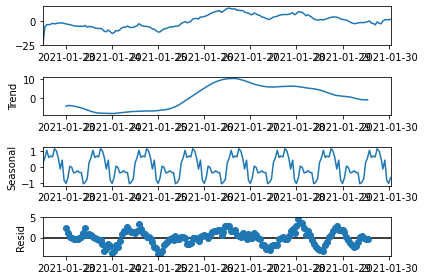

In [ ]:
seasonal_decompose(olsr_results.resid).plot()
plt.show()

Let's enlarge the seasonal plot.

<AxesSubplot:xlabel='date'>

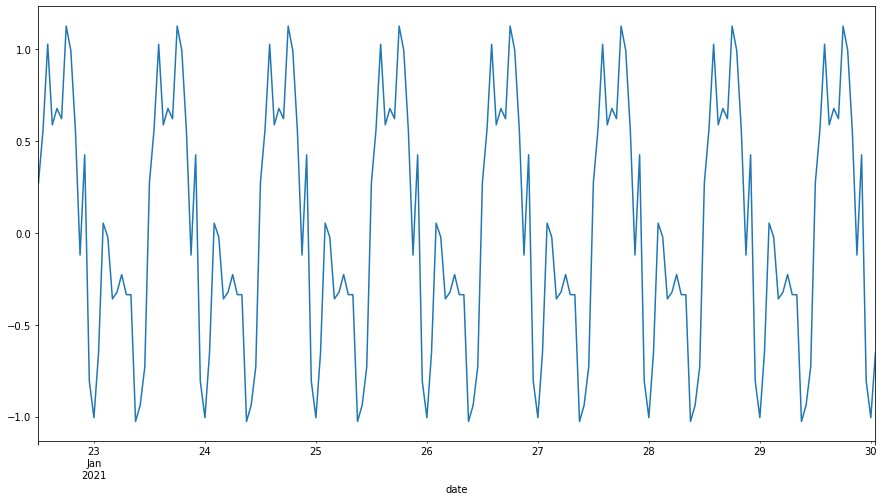

In [ ]:
components = seasonal_decompose(olsr_results.resid)
components.seasonal.plot(figsize=(15, 8))

The seasonal chart confirms that seasonal period is 24.

## Create the Model

In this step we are going to create the ARIMA model to forecast the value over time.

We begin with defining possible parameters combination.

In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

Next, we iterate through them and try to find the best one. For that, we are going to use AIC (Akaike Information Criterion). The lower it is - the better.

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_mae = 100000000
best_param = ''
best_seasonal_param = ''

for param in pdq:
    for param_seasonal in seasonal_pdq:
        mod = SARIMAX(endog=y_train,
                        exog=X_train_minus_intercept,
                        order=param,
                        seasonal_order=param_seasonal)

        results = mod.fit() 
        #print('Model: {}x{} - MAE:{}'.format(param, param_seasonal, results.mae))

        if results.mae > 0 and  results.mae < best_mae:
            best_mae = results.mae
            best_param = param
            best_seasonal_param = param_seasonal

print('Best model: {}x{} - MAE:{}'.format(best_param, best_seasonal_param, best_mae))

Best model: (1, 1, 1)x(1, 0, 1, 24) - MAE:5.642707465333495


We found out that parameters (1, 1, 1) for order and (1, 0, 1, 24) for seasonal order are the best ones. Let's train the model with these parameters.

In [11]:
sarimax_model = SARIMAX(endog=y_train,
                        exog=X_train_minus_intercept,
                        order=(1,1,1), 
                        seasonal_order=(1,0,1,24),
                        trend='n')
sarimax_results = sarimax_model.fit()
sarimax_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                air   No. Observations:                  182
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 24)   Log Likelihood                  -5.442
Date:                            Tue, 11 May 2021   AIC                             22.884
Time:                                    13:12:05   BIC                             42.075
Sample:                                01-22-2021   HQIC                            30.664
                                     - 01-30-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hum           -0.0027      0.031     -0.086      0.931      -0.063       0.058
ar.L1          0.8734      0.038     23.009      0.000       0.799       0.948
ma.L1          0.1710      0.077      2.234      0.025       0.021       0.321
ar.S.L24       0.6976      0.477      1.463      0.143      -0.237       1.632
ma.S.L24      -0.5920      0.513     -1.154      0.248      -1.597       0.413
sigma2         0.0613      0.006     11.138      0.000       0.051       0.072
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 8.21
Prob(Q):                              0.84   Prob(JB):                         0.02
Heteroskedasticity (H):               2.58   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
sarimax_results.mae

5.642707465333495

/root/venv/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


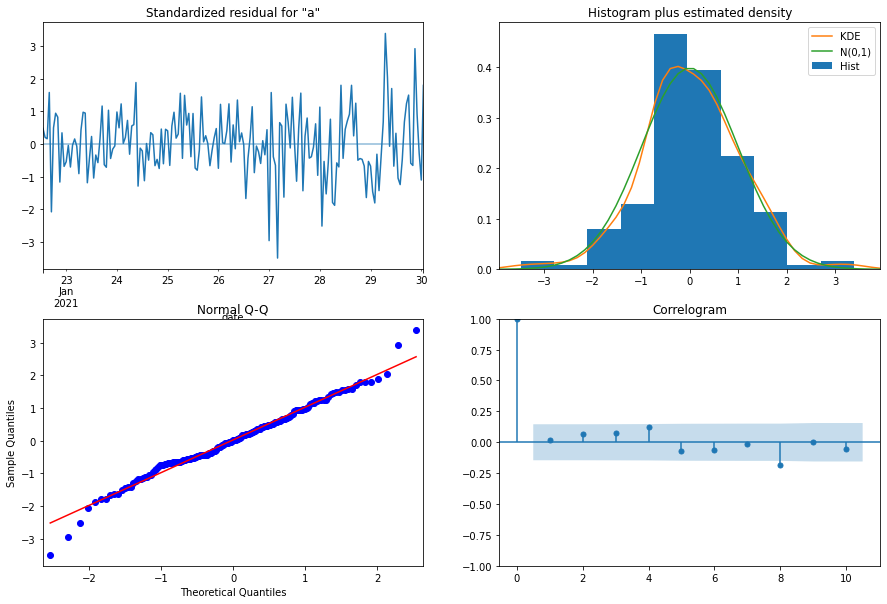

In [13]:
sarimax_results.plot_diagnostics(figsize=(15, 10))
plt.show()

Now, let's look how our new model works with the train data.

Finally, let's try to forecast new values. For that we are going to use test data.

In [14]:
X_test_minus_intercept = X_test.drop('Intercept', axis=1)
X_test_minus_intercept = X_test_minus_intercept.asfreq('H')
y_test = y_test.asfreq('H')

test_len = len(y_test)

# Get forecast for the test data
pred_uc = sarimax_results.get_forecast(steps=test_len, exog=X_test_minus_intercept[:test_len], dynamic=False)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

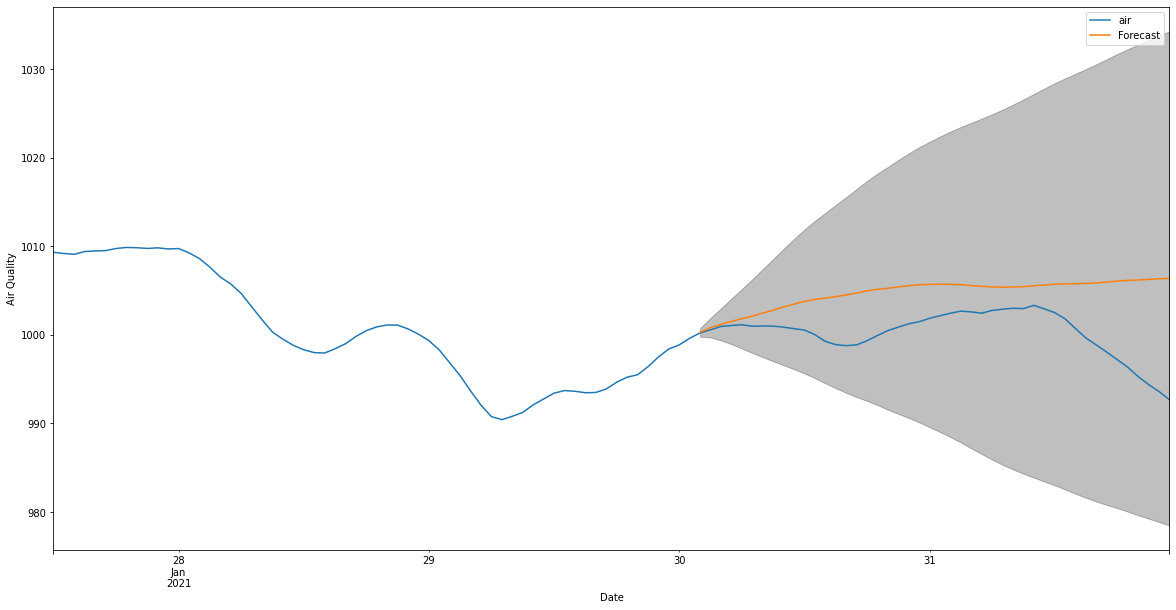

In [15]:
y = y_train[round(len(y_train)*0.66):].append(y_test)
ax = y.plot(label='Test', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Air Quality')

plt.legend()
plt.show()

## Model Saving

In the end, we need to save our machine learning model to reuse it later.

In [16]:
sarimax_results.save(f'{results_folder}/air.pkl')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=61a676f4-98d9-44f9-8970-d679f83b07e9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>